# Resonance SMILES Generation

This notebook is used for generating a representive set of resonance SMILES strings given a SMILES string of the parent molecule. As discussed in Zalte et al. (2025), this method uses automatic resonance generation capabilities that are a part of Reaction Mechanism Generator (RMG) package. RMG's `generate_resonance_structures()` was developed for constructing a set of representative resonance structures for arbitrary chemical species, including radicals and biradicals, consisting of the elements H, C, O, N, and S. Issues regarding the conversion of the genrated resonance RMG molecules to SMILES is fixed using `rdtools` module of the Reaction Data and Molecular Conformer (RDMC) package. Particularly, we use the `fix_mol` function to get valid spin conserving SMILES for all resonance structures of a given molecule. 

### Creating the environment

The following steps are requried for setting up the environment used to run this notebook.

1. Install the latest version of RMG-PY's molecule submodule by cloning the source code via Git. Make sure to start in an appropriate local directory where you want molecule folder to exist. 

    ```bash
    cd YourFolderPath
    git clone https://github.com/ReactionMechanismGenerator/molecule.git
    ```
2. Navigate to the molecule directory and create the conda environment for molecule.

    ```bash
    cd molecule 
    conda env create -f environment.yml --name=YourEnvName
    ```
3. Activate the environment and run `make` in the molecule folder to compile the cython files.

    ```bash
    conda activate YourEnvName
    make
    ```
4. Install RDMC by cloning the source code via Git. Ensure you are in the appropriate folder.

    ```bash
    cd YourFolderPath
    git clone https://github.com/xiaoruiDong/RDMC.git
    ```
5. Navigate to RDMC directory and switch the branch to `v1.0/dev` to gain access to the `rdtools` package.

    ```bash
    cd RDMC
    git checkout v1.0/dev
    ```
6. Install the package using PyPi.
    ```bash
    pip install -e .
    ```
7. Install jupyter to use this environment for Jupyter notebooks.
    ```bash
    pip install jupyter
    ```



### Imports

In [32]:

import sys
sys.path.append('/home/akshatz/bond_order_free/molecule/') # Replace the path with 'YourFolderPath/molecule/'
from molecule.molecule import Molecule,Group,ATOMTYPES
from rdkit import Chem
from rdkit.Chem import Draw
from rdtools.conversion.rmg import mol_from_rmg_mol
from rdtools.fix import fix_mol
from rdtools.mol import get_spin_multiplicity

import pandas as pd

### Function for generating a set of resonance SMILES given parent SMILES

In [33]:
def generate_resonance_structure_smis(parent_smi, allowed_atoms=["C", "H", "N", "O"]):
    """
    Generate resonance structures and their SMILES for a given parent SMILES.

    Input:
    parent_smi (str): The SMILES string of the parent molecule.
    allowed_atoms (list): A list of atom symbols that are allowed in the molecule (default: ["C", "H", "N", "O"]).

    Output:
    tuple:
        - (original SMILES (str), canonicalized resonance SMILES (list of str), number of unique resonance structures (int)):
        Returns the input parent SMILES, a list of resonance SMILES, and the number of resonance structures.

    Notes:
    - The function converts the input SMILES to both RDKit and RMG molecule objects for different operations.
    - It filters out molecules containing atoms not in the allowed atom list.
    - Resonance structures are generated using RMG's functionality and processed using RDKit for consistency.
    - Fixes issues related to spin multiplicity to ensure valid resonance structures.
    - Removes duplicates by canonicalizing the resulting SMILES representations.
    """

    parent_rdkit_mol = Chem.MolFromSmiles(parent_smi) # Convert the SMILES to RDKit molecule
    parent_multiplicity = get_spin_multiplicity(parent_rdkit_mol) # Obtain the spin multiplicity
    
    parent_rmg_mol = Molecule().from_smiles(parent_smi) # Convert the SMILES to RMG molecule
    # check if only allowed atoms are present in the molecule
    if any(a.symbol not in allowed_atoms for a in parent_rmg_mol.atoms):
        return None
    
    parent_rmg_mol.reactive = True # Set reactive=True
    reso_rmg_mols = parent_rmg_mol.generate_resonance_structures() # Generate a set of RMG molecules that are resonance structures of the given molecule
    
    reso_smis = set() # Initiate resonance SMILES
    for rmg_mol in reso_rmg_mols:
        reso_smi = rmg_mol.to_smiles() # Convert RMG molecule to SMILES
        reso_smis.add(reso_smi) # Add to resonance SMILES
    reso_smis = list(reso_smis)

    fixed_reso_smis = set() # Initiate fixed resonance SMILES
    reso_rdkit_mols = [Chem.MolFromSmiles(reso_smi) for reso_smi in reso_smis] # Convert resonance SMILES to RDKit molecules
    for rdkit_mol in reso_rdkit_mols:
        fixed_reso_mol = fix_mol(rdkit_mol, fix_spin_multiplicity=True, mult=parent_multiplicity) # Fix the molecule using fix_mol, input the multiplicity of the parent molecule
        [a.SetAtomMapNum(0) for a in fixed_reso_mol.GetAtoms()]
        fixed_reso_smis.add(Chem.MolToSmiles(fixed_reso_mol)) # Add the fixed resonance SMILES to the list

    # Canonicalize the fixed resronance SMILES and remove the duplicates
    canonical_reso_smis = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in fixed_reso_smis]
    canonical_reso_smis = list(set(canonical_reso_smis))
    num_resonance = len(canonical_reso_smis)

    return parent_smi, canonical_reso_smis, num_resonance

### Examples

#### Case: Resonance inactive molecules like methane, ethane, and cyclohexane.

In [34]:
smi = 'C'
generate_resonance_structure_smis(smi)

('C', ['C'], 1)

In [35]:
smi = 'CC'
parent_smi, reso_smis, num_reso = generate_resonance_structure_smis(smi)
print(parent_smi)
print(reso_smis)
print(num_reso)

CC
['CC']
1


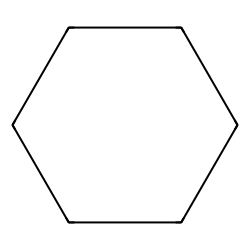

The molecule does not exhibit resonance.


In [36]:
smi = 'C1CCCCC1'
parent_smi, reso_smis, num_reso = generate_resonance_structure_smis(smi)
# Visualizing the molecules
reso_mols = [Chem.MolFromSmiles(smi) for smi in reso_smis]
img = Draw.MolsToGridImage(reso_mols, molsPerRow=1, subImgSize=(250, 250))
display(img)
print('The molecule does not exhibit resonance.')

#### Case: Closed shell resonance exhibiting molecules like benzene, and amide derivatives
**Note:** Benzene has only 1 canonicalized form! The two resonance structures can be represented using a single SMILES 

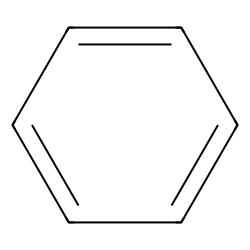

There is only 1 resonance structure after canonicalization.
Resonance SMILES: ['c1ccccc1']


In [37]:
smi = 'C1=CC=CC=C1' # Non-canonicalized SMILES
parent_smi, reso_smis, num_reso = generate_resonance_structure_smis(smi)
# Visualizing the molecules
reso_mols = [Chem.MolFromSmiles(smi) for smi in reso_smis]
img = Draw.MolsToGridImage(reso_mols, molsPerRow=1, subImgSize=(250, 250))
display(img)
print(f'There is only {num_reso} resonance structure after canonicalization.')
print(f'Resonance SMILES: {reso_smis}') # Output is a canonicalized SMILES

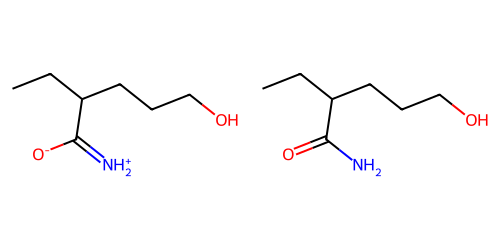

There are 2 resonance structures after canonicalization.
Resonance SMILES: ['CCC(CCCO)C(=[NH2+])[O-]', 'CCC(CCCO)C(N)=O']


In [38]:
smi = 'CCC(CCCO)C(N)=O'
parent_smi, reso_smis, num_reso = generate_resonance_structure_smis(smi)
# Visualizing the molecules
reso_mols = [Chem.MolFromSmiles(smi) for smi in reso_smis]
img = Draw.MolsToGridImage(reso_mols, molsPerRow=2, subImgSize=(250, 250))
display(img)
print(f'There are {num_reso} resonance structures after canonicalization.')
print(f'Resonance SMILES: {reso_smis}')

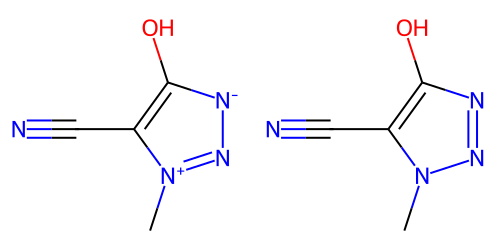

There are 2 resonance structures after canonicalization.
Resonance SMILES: ['C[n+]1n[n-]c(O)c1C#N', 'Cn1nnc(O)c1C#N']


In [39]:
smi = 'Cn1nnc(O)c1C#N'
parent_smi, reso_smis, num_reso = generate_resonance_structure_smis(smi)
# Visualizing the molecules
reso_mols = [Chem.MolFromSmiles(smi) for smi in reso_smis]
img = Draw.MolsToGridImage(reso_mols, molsPerRow=2, subImgSize=(250, 250))
display(img)
print(f'There are {num_reso} resonance structures after canonicalization.')
print(f'Resonance SMILES: {reso_smis}')

#### Case: Radicals that exhibit resonance like allylic radicals

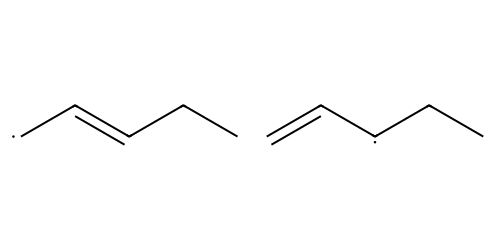

There are 2 resonance structures after canonicalization.
Resonance SMILES: ['[CH2]C=CCC', 'C=C[CH]CC']


In [40]:
smi = 'CCC=C[CH2]'
parent_smi, reso_smis, num_reso = generate_resonance_structure_smis(smi)
# Visualizing the molecules
reso_mols = [Chem.MolFromSmiles(smi) for smi in reso_smis]
img = Draw.MolsToGridImage(reso_mols, molsPerRow=2, subImgSize=(250, 250))
display(img)
print(f'There are {num_reso} resonance structures after canonicalization.')
print(f'Resonance SMILES: {reso_smis}')

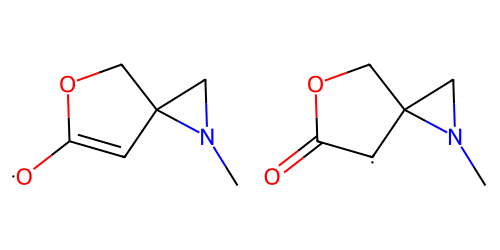

There are 2 resonance structures after canonicalization.
Resonance SMILES: ['CN1CC12C=C([O])OC2', 'CN1CC12[CH]C(=O)OC2']


In [41]:
smi = 'CN1CC12C=C([O])OC2'
parent_smi, reso_smis, num_reso = generate_resonance_structure_smis(smi)
# Visualizing the molecules
reso_mols = [Chem.MolFromSmiles(smi) for smi in reso_smis]
img = Draw.MolsToGridImage(reso_mols, molsPerRow=2, subImgSize=(250, 250))
display(img)
print(f'There are {num_reso} resonance structures after canonicalization.')
print(f'Resonance SMILES: {reso_smis}')

### Why was fix_mol needed? 
The conversion of RMG resonance molecules to SMILES can lead to multi-radical structures which are invalid resonance structures of the given molecule. We implement the simple fact that multiplicity is conserved between different resonance structures of the same molecule to fix the inavlid strcutures and their SMILES.

#### Example:

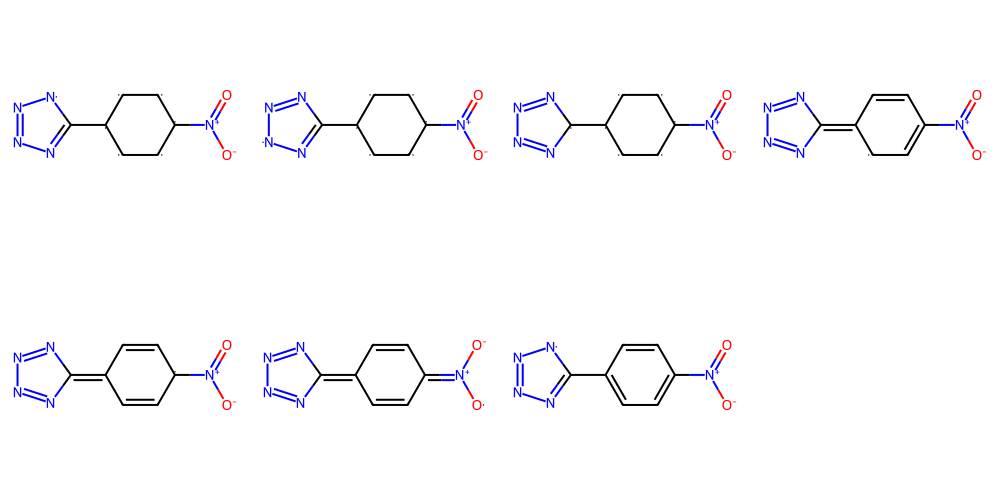

Output SMILES:
['O=[N+]([O-])[C]1[CH][CH][C](C2=NN=N[N]2)[CH][CH]1', 'O=[N+]([O-])[C]1[CH][CH][C](C2=N[N]N=N2)[CH][CH]1', 'O=[N+]([O-])[C]1[CH][CH][C]([C]2N=NN=N2)[CH][CH]1', 'O=[N+]([O-])C1=C[CH]C(=C2N=NN=N2)C=C1', 'O=[N+]([O-])[C]1C=CC(=C2N=NN=N2)C=C1', '[O][N+]([O-])=C1C=CC(=C2N=NN=N2)C=C1', 'O=[N+]([O-])c1ccc(C2=NN=N[N]2)cc1']


In [47]:

smi = "O=[N+]([O-])C1=CC=C(C2=NN=N[N]2)C=C1"
mol = Molecule().from_smiles(smi)
mols = mol.generate_resonance_structures() # Using only RMG's function
smis = [mol.to_smiles() for mol in mols] # This is where it all goes wrong
can_smis = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in smis]
# Visualizing the molecules
reso_mols = [Chem.MolFromSmiles(smi) for smi in can_smis]
img = Draw.MolsToGridImage(reso_mols, molsPerRow=4, subImgSize=(250, 250))
display(img)
print("Output SMILES:")
print(can_smis)

Clearly, the first three structures/SMILES are invalid resonance structures of the given molecule. Our function solves this problem by using the fact that this is a single radical structure to begin with.

#### Using `fix_mol()`

Given molecule:


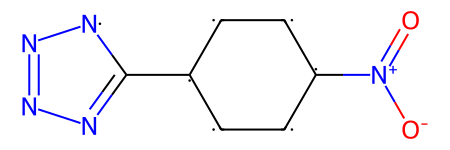

Fixed molecule:


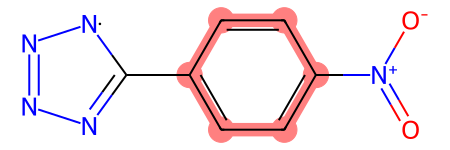

In [43]:
inval_smi = can_smis[0]
inval_mol = Chem.MolFromSmiles(inval_smi)
print("Given molecule:")
display(inval_mol)
fixed_mol = fix_mol(inval_mol, fix_spin_multiplicity=True, mult=2, renumber_atoms=False)
print("Fixed molecule:")
display(fixed_mol)

Our function leverages this to fix the genearted resonance SMILES and also filters out the duplicates (removes identical fixed and canonicalized SMILES)

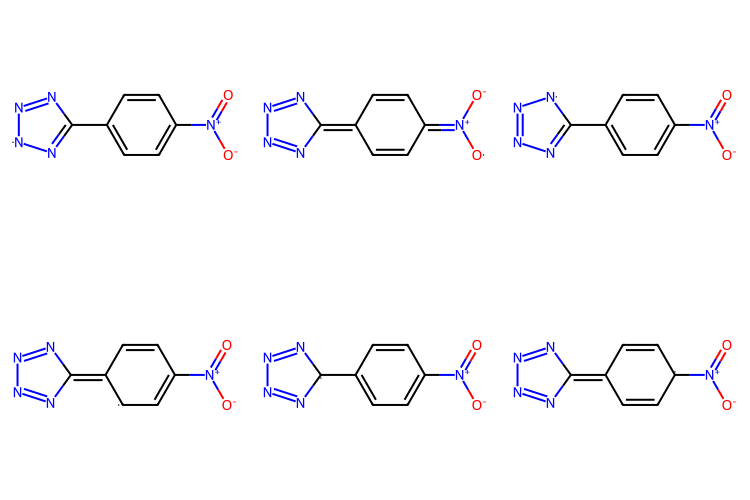

There are 6 resonance structures.
Resonance SMILES: ['O=[N+]([O-])c1ccc(C2=N[N]N=N2)cc1', '[O][N+]([O-])=C1C=CC(=C2N=NN=N2)C=C1', 'O=[N+]([O-])c1ccc(C2=NN=N[N]2)cc1', 'O=[N+]([O-])C1=C[CH]C(=C2N=NN=N2)C=C1', 'O=[N+]([O-])c1ccc([C]2N=NN=N2)cc1', 'O=[N+]([O-])[C]1C=CC(=C2N=NN=N2)C=C1']


In [49]:
smi = 'O=[N+]([O-])C1=CC=C(C2=NN=N[N]2)C=C1'
parent_smi, reso_smis, num_reso = generate_resonance_structure_smis(smi)
# Visualizing the molecules
reso_mols = [Chem.MolFromSmiles(smi) for smi in reso_smis]
img = Draw.MolsToGridImage(reso_mols, molsPerRow=3, subImgSize=(250, 250))
display(img)
print(f'There are {num_reso} resonance structures.')
print(f'Resonance SMILES: {reso_smis}')

## Data Augmentation using Resonance structures
Given a dataset with molecule SMILES and target property. One can leverage the `generate_resonance_structure_smis()` function to augment the dataset with resonance structures. As per Zalte et al. (2025), such augmentation can help learn resonance invariance and improve the model performance.

In [45]:
def augment_with_resonance(df, smiles_col, property_col):
    """
    Augments the given DataFrame with resonance SMILES generated from the parent SMILES.
    For each row in the DataFrame, it generates the resonance structures, excludes the 
    parent SMILES from the resonance list, and appends the resonance SMILES to the DataFrame
    with the same target value.

    Args:
        df (pd.DataFrame): A DataFrame containing at least two columns:
                            - `smiles_col` (str): The column name containing the SMILES representation of molecules.
                            - `property_col` (str): The column name containing the target property associated with each SMILES.
        smiles_col (str): The name of the column containing the SMILES representation of the molecules.
        property_col (str): The name of the column containing the target property values.

    Returns:
        pd.DataFrame: A new DataFrame with resonance SMILES and the corresponding target properties.
                       The parent SMILES are not repeated, and only resonance structures are added.
    """

    # Initialize lists for the new augmented data
    augmented_smiles = []
    augmented_target_values = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        smiles = row[smiles_col]
        target_value = row[property_col]
        
        # Get the resonance SMILES and number of resonance structures
        _, reso_smis, _ = generate_resonance_structure_smis(smiles)
        
        # Add only the resonance SMILES (excluding the parent SMILES if it's already in the resonance set)
        for reso_smi in reso_smis:
            augmented_smiles.append(reso_smi)
            augmented_target_values.append(target_value)

    # Create the augmented DataFrame
    augmented_df = pd.DataFrame({
        'SMILES': augmented_smiles,
        'Target_Property': augmented_target_values
    })

    return augmented_df

### Example
Here we use a toy dataset as augmenting a large dataset is time-consuming. The dummy dataset has 5 unique molecules with random property values. The dataset is a mix of non-resonance, resonance radicals, and resonance closed-shell species.

In [46]:
import pandas as pd
# Define the SMILES and dummy target property values
smiles = [
    "C", 
    "C1CCCCC1", 
    "CCC(CCCO)C(N)=O", 
    "CCC=C[CH2]", 
    "O=[N+]([O-])C1=CC=C(C2=NN=N[N]2)C=C1"
]
dummy_target_values = [1.5, 2.3, 0.9, 3.2, 1.1]

# Create a DataFrame
df = pd.DataFrame({
    'SMILES': smiles,
    'Property': dummy_target_values
})
print("Given dataset:")
display(df)
# Augment with resonance
augmented_df = augment_with_resonance(df, "SMILES", "Property")
print("Augmented dataset:")
display(augmented_df)

Given dataset:


,SMILES,Property
0,C,1.5
1,C1CCCCC1,2.3
2,CCC(CCCO)C(N)=O,0.9
3,CCC=C[CH2],3.2
4,O=[N+]([O-])C1=CC=C(C2=NN=N[N]2)C=C1,1.1


Augmented dataset:


,SMILES,Target_Property
0,C,1.5
1,C1CCCCC1,2.3
2,CCC(CCCO)C(=[NH2+])[O-],0.9
3,CCC(CCCO)C(N)=O,0.9
4,[CH2]C=CCC,3.2
5,C=C[CH]CC,3.2
6,O=[N+]([O-])c1ccc(C2=N[N]N=N2)cc1,1.1
7,[O][N+]([O-])=C1C=CC(=C2N=NN=N2)C=C1,1.1
8,O=[N+]([O-])c1ccc(C2=NN=N[N]2)cc1,1.1
9,O=[N+]([O-])C1=C[CH]C(=C2N=NN=N2)C=C1,1.1


**Note:** For the QuantumPioneer dataset, we use a slightly different strategy to rapidly sample 20,000 resonance radicals, 20,000 resonance closed-shell species and 10,000 non-resonance species, however, the overall method is the same. 